# Segmentation

We have already learnt about Object Detection, which allows us to locate objects in the image by predicting their *bounding boxes*. However, for some tasks we do not only need bounding boxes, but also more precise object localization. This task is called  **segmentation**.

Segmentation can be viewed as **pixel classification**, whereas for **each** pixel of image we must predict its class (*background* being one of the classes). There are two main segmentation algorithms:

* **Semantic segmentation** only tells pixel class, and does not make a distinction between different objects of the same class
* **Instance segmentation** divides classes into different instances. 

For instance segmentation 10 sheep are different objects, for semantic segmentation all sheep are represented by one class.

<img src="images/instance_vs_semantic.jpeg" width="50%">

> Image from [this blog post](https://nirmalamurali.medium.com/image-classification-vs-semantic-segmentation-vs-instance-segmentation-625c33a08d50)

There are different neural architectures for segmentation, but they all have the same structure:

* **Encoder** extracts features from input image
* **Decoder** transforms those features into the **mask image**, with the same size and number of channels corresponding to the number of classes.

<img src="images/segm.png" width="80%">

> Image from [this publication](https://arxiv.org/pdf/2001.05566.pdf)



## Prerequsites

To begin with, we will import required libraries, and check if there is GPU available for training.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn
from torch import optim
from tqdm import tqdm
import numpy as np
import torch.nn.functional as F
from skimage.io import imread
from skimage.transform import resize
import os
torch.manual_seed(42)
np.random.seed(42)

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
train_size = 0.9
lr = 1e-3
weight_decay = 1e-6
batch_size = 32
epochs = 30

## The Dataset

We will use the <a href="https://www.fc.up.pt/addi/ph2%20database.html">PH<sup>2</sup> Database</a> of dermoscopy images of human nevi. This dataset contains 200 images of three classes: typical nevus, atypical nevus, and melanoma. All images also contain corresponding **mask** that outline the nevus.

The code below downloads the dataset from the original location and decompresses it. You would need to have `unrar` utility installed in order for this code to work, you may install it using `sudo apt-get install unrar` on Linux, or by downloading command-line version for Windows [here](https://www.rarlab.com/rar_add.htm).

In [4]:
# !apt-get install rar
# !wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
!unrar x -Y PH2Dataset.rar


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from PH2Dataset.rar

Creating    PH2Dataset                                                OK
Extracting  PH2Dataset/PH2_dataset.txt                                   0  OK 
Extracting  PH2Dataset/PH2_dataset.xlsx                                  0  OK 
Extracting  PH2Dataset/Readme.txt                                        0  OK 
Creating    PH2Dataset/PH2 Dataset images                             OK
Creating    PH2Dataset/PH2 Dataset images/IMD002                      OK
Creating    PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image  OK
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp     0  OK 
Creating    PH2Dataset/PH2 Dataset images/IMD002/IMD002_lesion        OK
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_lesion/IMD002_lesion.bmp     0  OK 
Creating    PH2Dataset/PH2 Dataset images/IMD002/IMD002_roi           OK
Extracting  PH2Datase

Now we will define the code to load the dataset. We will transform all images into 256x256 size, and split the dataset into train and test part. This function returns train and test datasets, each containing original images and masks outlining the nevus.

In [5]:
def load_dataset(train_part, root='PH2Dataset'):
    images = []
    masks = []

    for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
        if root.endswith('_Dermoscopic_Image'):
            images.append(imread(os.path.join(root, files[0])))
        if root.endswith('_lesion'):
            masks.append(imread(os.path.join(root, files[0])))

    size = (256, 256)
    images = torch.permute(torch.FloatTensor(np.array([resize(image, size, mode='constant', anti_aliasing=True,) for image in images])), (0, 3, 1, 2))
    masks = torch.FloatTensor(np.array([resize(mask, size, mode='constant', anti_aliasing=False) > 0.5 for mask in masks])).unsqueeze(1)

    indices = np.random.permutation(range(len(images)))
    train_part = int(train_part * len(images))
    train_ind = indices[:train_part]
    test_ind = indices[train_part:]

    train_dataset = (images[train_ind, :, :, :], masks[train_ind, :, :, :])
    test_dataset = (images[test_ind, :, :, :], masks[test_ind, :, :, :])

    return train_dataset, test_dataset

train_dataset, test_dataset = load_dataset(train_size)

Let's now plot some of the images from the dataset to see how they look like:

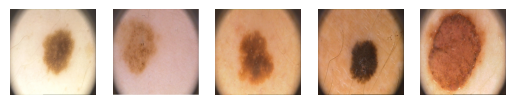

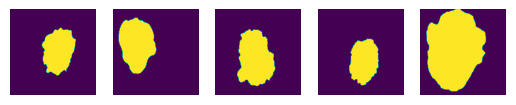

In [6]:
def plotn(n, data, only_mask=False):
    images, masks = data[0], data[1]
    fig, ax = plt.subplots(1, n)
    fig1, ax1 = plt.subplots(1, n)
    for i, (img, mask) in enumerate(zip(images, masks)):
        if i == n:
            break
        if not only_mask:
            ax[i].imshow(torch.permute(img, (1, 2, 0)))
        else:
            ax[i].imshow(img[0])
        ax1[i].imshow(mask[0])
        ax[i].axis('off')
        ax1[i].axis('off')
    plt.show()

plotn(5, train_dataset)

We will also need dataloaders to feed the data into our neural network.

In [7]:
train_dataloader = torch.utils.data.DataLoader(list(zip(train_dataset[0], train_dataset[1])), batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(list(zip(test_dataset[0], test_dataset[1])), batch_size=1, shuffle=False)
dataloaders = (train_dataloader, test_dataloader)

## SegNet

The simplest encoder-decoder architecture is called **SegNet**. It uses standard CNN with convolutions and poolings in the encoder, and deconvolution CNN that includes convolutions and upsamplings in decoder. It also relies on batch normalization to train multi-layered network successfully.

<img src="images/segnet.png" width="80%">

> Image from this paper: Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [8]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.act0 = nn.ReLU()
        self.bn0 = nn.BatchNorm2d(16)
        self.pool0 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 =  nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 =  nn.MaxPool2d(kernel_size=(2,2))

        self.bottleneck_conv = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)
        
        self.upsample0 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv0 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3), padding=1)
        self.dec_act0 = nn.ReLU()
        self.dec_bn0 = nn.BatchNorm2d(128)

        self.upsample1 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv1 =  nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3), padding=1)
        self.dec_act1 = nn.ReLU()
        self.dec_bn1 = nn.BatchNorm2d(64)

        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)
        
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), padding=1)
        self.dec_act2 = nn.ReLU()
        self.dec_bn2 = nn.BatchNorm2d(32)

        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(1,1))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e0 = self.pool0(self.bn0(self.act0(self.enc_conv0(x))))
        e1 = self.pool1(self.bn1(self.act1(self.enc_conv1(e0))))
        e2 = self.pool2(self.bn2(self.act2(self.enc_conv2(e1))))
        e3 = self.pool3(self.bn3(self.act3(self.enc_conv3(e2))))

        b = self.bottleneck_conv(e3)

        d0 = self.dec_bn0(self.dec_act0(self.dec_conv0(self.upsample0(b))))
        d1 = self.dec_bn1(self.dec_act1(self.dec_conv1(self.upsample1(d0))))
        d2 = self.dec_bn2(self.dec_act2(self.dec_conv2(self.upsample2(d1))))
        d3 = self.sigmoid(self.dec_conv3(self.upsample3(d2)))
        return d3

We should especially mention the loss function that is used for segmentation. In classical autoencoders we need to measure the similarity between two images, and we can use mean square error to do that. In segmentation, each pixel in the target mask image represents the class number (one-hot-encoded along the third dimension), so we need to use loss functions specific for classification - cross-entropy loss, averaged over all pixels. If the mask is binary (as in our example) - we will use **binary cross-entropy loss** (BCE).   

In [9]:
model = SegNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss()

Training loop is defined in the usual way:

In [10]:
def train(dataloaders, model, loss_fn, optimizer, epochs, device):
    tqdm_iter = tqdm(range(epochs))
    train_dataloader, test_dataloader = dataloaders[0], dataloaders[1]

    for epoch in tqdm_iter:
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        for batch in train_dataloader:
            imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)

            preds = model(imgs)
            loss = loss_fn(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        model.eval()
        with torch.no_grad():
            for batch in test_dataloader:
                imgs, labels = batch
                imgs = imgs.to(device)
                labels = labels.to(device)

                preds = model(imgs)
                loss = loss_fn(preds, labels)

                test_loss += loss.item()

        train_loss /= len(train_dataloader)
        test_loss /= len(test_dataloader)

        tqdm_dct = {'train loss:': train_loss, 'test loss:': test_loss}
        tqdm_iter.set_postfix(tqdm_dct, refresh=True)
        tqdm_iter.refresh()

In [11]:
train(dataloaders, model, loss_fn, optimizer, epochs, device)

100%|██████████| 30/30 [00:13<00:00,  2.31it/s, train loss:=0.595, test loss:=0.592]


To evaluate our model, we will just plot target masks and predicted masks for a number of images:

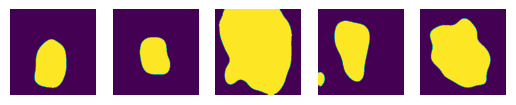

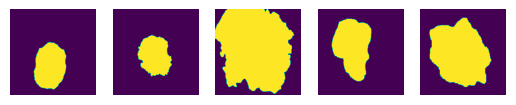

In [12]:
model.eval()
predictions = []
image_mask = []
plots = 5
images, masks = test_dataset[0], test_dataset[1]
for i, (img, mask) in enumerate(zip(images, masks)):
    if i == plots:
        break
    img = img.to(device).unsqueeze(0)
    predictions.append((model(img).detach().cpu()[0] > 0.5).float())
    image_mask.append(mask)
plotn(plots, (predictions, image_mask), only_mask=True)

There are also some formal metrics to evaluate the performance, which you can read about [here](https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2). The easiest one to understand is **pixel accuracy** - a percentage of pixels classified correctly.

## U-Net

SegNet architecture is very natural, but it is not the most accurate. Indeed, we first apply pyramid CNN architecture to the original image, which reduces the spatial accuracy of image features. Then, when we reconstruct the image, we cannot correctly reconstruct the pixel positions.

This leads us to the idea of **skip connections** between convolution layers in encoder and decoder. This architecture is very common for semantic segmentation, and is called **U-Net**. Skip connections at each convolution level helps network not to lose information about features from original input at this level.

We will use quite simple CNN architecture here, but U-Net can also use more complex encoder for feature extraction, such as ResNet-50.

<img src="images/unet.png" width="70%">

> Image from paper: Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. [U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)

In [13]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.act0 = nn.ReLU()
        self.bn0 = nn.BatchNorm2d(16)
        self.pool0 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 =  nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 =  nn.MaxPool2d(kernel_size=(2,2))

        self.bottleneck_conv = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)
        
        self.upsample0 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv0 = nn.Conv2d(in_channels=384, out_channels=128, kernel_size=(3,3), padding=1)
        self.dec_act0 = nn.ReLU()
        self.dec_bn0 = nn.BatchNorm2d(128)

        self.upsample1 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv1 =  nn.Conv2d(in_channels=192, out_channels=64, kernel_size=(3,3), padding=1)
        self.dec_act1 = nn.ReLU()
        self.dec_bn1 = nn.BatchNorm2d(64)

        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv2 = nn.Conv2d(in_channels=96, out_channels=32, kernel_size=(3,3), padding=1)
        self.dec_act2 = nn.ReLU()
        self.dec_bn2 = nn.BatchNorm2d(32)

        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv3 = nn.Conv2d(in_channels=48, out_channels=1, kernel_size=(1,1))

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e0 = self.pool0(self.bn0(self.act0(self.enc_conv0(x))))
        e1 = self.pool1(self.bn1(self.act1(self.enc_conv1(e0))))
        e2 = self.pool2(self.bn2(self.act2(self.enc_conv2(e1))))
        e3 = self.pool3(self.bn3(self.act3(self.enc_conv3(e2))))

        cat0 = self.bn0(self.act0(self.enc_conv0(x)))
        cat1 = self.bn1(self.act1(self.enc_conv1(e0)))
        cat2 = self.bn2(self.act2(self.enc_conv2(e1)))
        cat3 = self.bn3(self.act3(self.enc_conv3(e2)))

        b = self.bottleneck_conv(e3)

        d0 = self.dec_bn0(self.dec_act0(self.dec_conv0(torch.cat((self.upsample0(b), cat3), dim=1))))
        d1 = self.dec_bn1(self.dec_act1(self.dec_conv1(torch.cat((self.upsample1(d0), cat2), dim=1))))
        d2 = self.dec_bn2(self.dec_act2(self.dec_conv2(torch.cat((self.upsample2(d1), cat1), dim=1))))
        d3 = self.sigmoid(self.dec_conv3(torch.cat((self.upsample3(d2), cat0), dim=1)))
        return d3

In [14]:
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss()

In [15]:
train(dataloaders, model, loss_fn, optimizer, epochs, device)

100%|██████████| 30/30 [00:16<00:00,  1.77it/s, train loss:=0.595, test loss:=0.594]


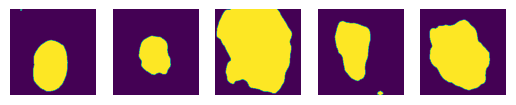

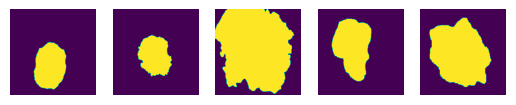

In [16]:
model.eval()
predictions = []
image_mask = []
plots = 5
images, masks = test_dataset[0], test_dataset[1]
for i, (img, mask) in enumerate(zip(images, masks)):
    if i == plots:
        break
    img = img.to(device).unsqueeze(0)
    predictions.append((model(img).detach().cpu()[0] > 0.5).float())
    image_mask.append(mask)
plotn(plots, (predictions, image_mask), only_mask=True)